In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Hyperparameter tuning with Random Forest

Based on https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
plt.rcParams['figure.figsize'] = 9, 6

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

## Plotting function

In [3]:
def plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.title("Validation Curve")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.991, 1.001)
    lw = 2
    plt.semilogx(param_range, 
                 train_scores_mean, 
                 label="Training score",
                 color="darkorange", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2,
                     color="darkorange", 
                     lw=lw
                    )
    plt.semilogx(param_range, 
                 test_scores_mean, 
                 label="Cross-validation score",
                 color="navy", 
                 lw=lw
                )
    plt.fill_between(param_range, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.2,
                     color="navy", 
                     lw=lw
                    )
    plt.legend(loc="best")    
    return

## Wine dataset with split ratio 65:35
URL https://archive.ics.uci.edu/ml/datasets/wine+quality

In [4]:
red = pd.read_csv('data/winequality-red.csv', delimiter=';')
red['color'] = 1

white = pd.read_csv('data/winequality-white.csv', delimiter=';')
white['color'] = 0

data = pd.concat([red, white], ignore_index=True, sort=False)
n_samples, n_features = data.shape
n_samples, n_features

(6497, 13)

#### add noisy columns (simulate real data)

In [5]:
# you can try a change to 100 to see computational effect
n_cols = 20 * n_features
random_state = np.random.RandomState(0)
df_cols = pd.DataFrame(data=random_state.randn(n_samples, n_cols),
                       columns=range(1, n_cols+1)
                      )
print(df_cols.shape)

data = pd.concat([data, df_cols], axis=1)
data.shape

(6497, 260)


(6497, 273)

#### split dataset

In [6]:
train, test = train_test_split(data, test_size=0.35, shuffle=True, stratify=None)
print(len(train), len(test))

x_train, y_train = train.loc[:, train.columns != 'color'], train['color']
x_test, y_test = test.loc[:, test.columns != 'color'], test['color']

4223 2274


## Random Forest classifier

In [7]:
# default n_estimators=100
forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.9890061565523307


## Hyperparameter *n_estimators* tuning
**Note: long running time - a few minutes**

In [8]:
param_range = [100, 200, 300, 400, 500]

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             X = x_train, 
                                             y = y_train, 
                                             param_name = 'n_estimators', 
                                             param_range = param_range, 
                                             scoring="accuracy",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(train_scores)
print(test_scores)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.99147727 0.98295455 0.99076048]
 [0.9921875  0.98153409 0.99147122]
 [0.99289773 0.98224432 0.99218195]
 [0.99289773 0.98295455 0.99289268]
 [0.99360795 0.98082386 0.99360341]]


## Plotting

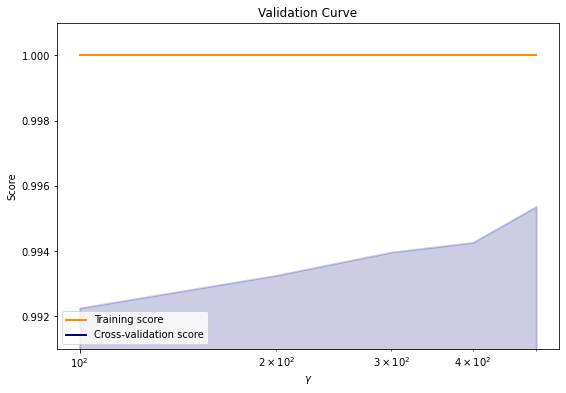

In [9]:
plot_valid_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

## Random Forest with hyperparameter setting

In [10]:
forest = RandomForestClassifier(random_state = 1,
                                n_estimators = 200,
                                max_depth = None, 
                                min_samples_split = 2,  
                                min_samples_leaf = 1
                               ) 
model = forest.fit(x_train, y_train) 
y_pred = model.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.9916446789797714


## Grid Search
**Note: long running time cca 30m**

In [11]:
# n_estimators = [100, 200, 300, 400, 500]
n_estimators = [100, 200, 300]
max_depth = [5, 10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10] 

hyper = dict(n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )
gs = GridSearchCV(forest, hyper, cv=3, verbose=1, n_jobs=-1)

best = gs.fit(x_train, y_train)
print(best)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=200, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             verbose=1)


## The best model

In [12]:
forest = RandomForestClassifier(n_estimators=200, random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.9916446789797714


# DÚ (len) na rozmýšľanie:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- different split ratio 65:35, 70:30, 75:26, 80:20
- different hyperpamater setting
- different criterion{“gini”, “entropy”}
- different classifiers
- different metrics
- different datasets

**The quest**
- What is the best model?
- Is the score good enough?
- Do we need more tuning for this concrete case?

**Auxiliary**
- Nice visualizations of data and/or results